In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from physical_model import drymodel
from ml_model import model

In [3]:
def flatten_state(psi):
    return psi.ravel()

def unflatten_state(vec, nx, ny, n_layers=2):
    return vec.reshape(nx, ny, n_layers)

def build_observation_indices(nx, ny, n_layers=2, stride=8, layer=0):
    idxs = []
    for i in range(0, nx, stride):
        for j in range(0, ny, stride):
            idx = ((i * ny) + j) * n_layers + layer
            idxs.append(idx)
    return np.array(idxs, dtype=np.int64)

In [4]:
# Generate truth trajectory using the physical QG model and synthetic observations with Gaussian noise
def generate_truth_and_observations(T, n_transient=100, sigma_obs=0.5, stride=8, seed=0,):
    rng = np.random.default_rng(seed)

    # Initial condition
    psi0 = rng.standard_normal((96, 192, 2))

    psi = psi0.copy()
    for _ in range(n_transient):
        psi = drymodel(psi)

    # Truth trajectory
    psi_truth = [psi.copy()]
    for _ in range(T):
        psi = drymodel(psi)
        psi_truth.append(psi.copy())

    nx, ny, n_layers = psi_truth[0].shape

    obs_idx = build_observation_indices(
        nx, ny, n_layers, stride=stride, layer=0
    )
    m = len(obs_idx)

    R = (sigma_obs ** 2) * np.eye(m)

    # Generate observations
    y_obs = []
    for t in range(1, T + 1):
        x_vec = flatten_state(psi_truth[t])
        y_clean = x_vec[obs_idx]
        noise = rng.normal(0.0, sigma_obs, size=m)
        y_obs.append(y_clean + noise)

    return psi_truth, y_obs, obs_idx, R


In [5]:
T = 50
psi_truth, y_obs, obs_idx, R = generate_truth_and_observations(
    T=T,
    n_transient=100,
    sigma_obs=0.5,
    stride=8,
    seed=10,
)

print(f"Number of time steps (truth): {len(psi_truth) - 1}")
print(f"State shape: {psi_truth[0].shape}")
print(f"Observation dimension m = {len(obs_idx)}")

complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)


/Users/huanghongxiao/Desktop/Uchicago/Inverse Problem/HW/acm270_projects-main/Project 3/physical_model.py:68: RuntimeWarning: divide by zero encountered in divide
  psi_Rc = -np.fft.fft(  u_eq ) / 1.j / ll
/Users/huanghongxiao/Desktop/Uchicago/Inverse Problem/HW/acm270_projects-main/Project 3/physical_model.py:68: RuntimeWarning: invalid value encountered in divide
  psi_Rc = -np.fft.fft(  u_eq ) / 1.j / ll
/Users/huanghongxiao/Desktop/Uchicago/Inverse Problem/HW/acm270_projects-main/Project 3/physical_model.py:195: ComplexWarning: Casting complex values to real discards the imaginary part
  forc1[:, :] = (psi_1[1] - psi_2[1] - psi_R[:, np.newaxis]) / tau_d
/Users/huanghongxiao/Desktop/Uchicago/Inverse Problem/HW/acm270_projects-main/Project 3/physical_model.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  forc2[:, :] = -(psi_1[1] - psi_2[1] - psi_R[:, np.newaxis]) / tau_d
/Users/huanghongxiao/Desktop/Uchicago/Inverse Problem/HW/acm270_projects-main/

complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spec

In [6]:
# CRPS for ensemble of scalar samples and a scalar observation
def crps_ensemble(samples, y):

    x = np.asarray(samples).ravel()
    N = x.size
    term1 = np.mean(np.abs(x - y))

    diff = np.abs(x[:, None] - x[None, :])
    term2 = 0.5 * np.mean(diff)
    return term1 - term2


In [7]:
# Forecast step using the physical QG 
def step_physical_ensemble(ensemble):
    Ne = ensemble.shape[0]
    out = []
    for i in range(Ne):
        out.append(drymodel(ensemble[i]))
    return np.stack(out, axis=0)

# Forecast step using the ML surrogate 
def step_ml_ensemble(ensemble):
    Ne, nx, ny, n_layers = ensemble.shape
    batch = ensemble.transpose(0, 2, 1, 3)       
    out = model.predict(batch, verbose=0)        
    out = out.transpose(0, 2, 1, 3)              
    return out

In [8]:
def idx_to_coord(idx, nx, ny, n_layers):
    layer = idx % n_layers
    tmp = idx // n_layers
    j = tmp % ny
    i = tmp // ny
    return i, j, layer

# Build a state–observation localization matrix
def build_localization_xy(nx, ny, n_layers, obs_idx, ell, periodic=True, dtype=np.float32):
    d = nx * ny * n_layers
    m = len(obs_idx)

    state_coords = np.zeros((d, 2), dtype=np.int32)  
    for i in range(nx):
        for j in range(ny):
            for l in range(n_layers):
                idx = ((i * ny) + j) * n_layers + l
                state_coords[idx, 0] = i
                state_coords[idx, 1] = j

    obs_coords = np.zeros((m, 2), dtype=np.int32)
    for k, idx in enumerate(obs_idx):
        i, j, layer = idx_to_coord(idx, nx, ny, n_layers)
        obs_coords[k, 0] = i
        obs_coords[k, 1] = j

    si = state_coords[:, 0][:, None]  
    sj = state_coords[:, 1][:, None]  
    oi = obs_coords[:, 0][None, :]    
    oj = obs_coords[:, 1][None, :]    

    dx = si - oi  
    dy = sj - oj 

    if periodic:
        dx = np.minimum(np.abs(dx), nx - np.abs(dx))
        dy = np.minimum(np.abs(dy), ny - np.abs(dy))
    else:
        dx = np.abs(dx)
        dy = np.abs(dy)

    D2 = dx.astype(np.float64) ** 2 + dy.astype(np.float64) ** 2

    L_xy = np.exp(-D2 / (ell), dtype=np.float64)
    L_xy = L_xy.astype(dtype)

    print("L_xy shape:", L_xy.shape)
    print("L_xy min, max:", float(np.min(L_xy)), float(np.max(L_xy)))
    print("Any non-finite in L_xy?", not np.all(np.isfinite(L_xy)))

    return L_xy

In [9]:
def enkf_analysis(X_f, y_obs_t, obs_idx, R, inflation=None, rng=None, L_xy=None):

    if rng is None:
        rng = np.random.default_rng()

    d, Ne = X_f.shape
    m = len(obs_idx)

    # Forecast mean and anomalies
    x_bar = X_f.mean(axis=1, keepdims=True)  
    A = X_f - x_bar                           

    if inflation is not None:
        A *= inflation
        X_f = x_bar + A

    Y_f = X_f[obs_idx, :]                     
    y_bar = Y_f.mean(axis=1, keepdims=True)  
    Ay = Y_f - y_bar                          

    # Sample covariances
    factor = 1.0 / (Ne - 1)
    P_xy = factor * (A @ Ay.T)                
    P_yy = factor * (Ay @ Ay.T) + R           

    # Kalman gain 
    K = np.linalg.solve(P_yy.T, P_xy.T).T     

    # Apply localization on K
    if L_xy is not None:
       
        K = K * L_xy

    # Perturbed observations
    eps = rng.multivariate_normal(
        mean=np.zeros(m),
        cov=R,
        size=Ne,
    ).T                                       
    Y_tilde = y_obs_t[:, None] + eps          


    innovation = Y_tilde - Y_f                
    X_a = X_f + K @ innovation                

    return X_a

def run_enkf(
    psi_truth,
    y_obs,
    obs_idx,
    R,
    forecast_step,
    Ne=20,
    sigma_init=1.0,
    inflation=None,
    seed=0,
    compute_crps=False,
    L_xy=None,   
):
    rng = np.random.default_rng(seed)

    T = len(y_obs)
    nx, ny, n_layers = psi_truth[0].shape
    d = nx * ny * n_layers

    # Flatten truth trajectory
    truth_vecs = np.array(
        [flatten_state(psi_truth[t]) for t in range(T + 1)]
    ) 

    # Initial state
    x0_truth = truth_vecs[0]
    X_a = x0_truth[:, None] + sigma_init * rng.standard_normal((d, Ne))

    X_means = np.zeros((T + 1, d))
    X_means[0, :] = X_a.mean(axis=1)

    if compute_crps:
        crps = np.zeros(T + 1)
        crps[0] = np.nan

    for t in range(T):
        ensemble_fields = np.stack(
            [
                unflatten_state(X_a[:, i], nx, ny, n_layers)
                for i in range(Ne)
            ],
            axis=0,
        )  

        ensemble_forecast = forecast_step(ensemble_fields)

        X_f = np.stack(
            [flatten_state(ensemble_forecast[i]) for i in range(Ne)],
            axis=1,
        )  

        X_a = enkf_analysis(
            X_f,
            y_obs_t=y_obs[t],
            obs_idx=obs_idx,
            R=R,
            inflation=inflation,
            rng=rng,
            L_xy=L_xy,
        )

        X_means[t + 1, :] = X_a.mean(axis=1)

        if compute_crps:
            truth_obs = truth_vecs[t + 1][obs_idx]   
            ens_obs = X_a[obs_idx, :].T             

            m = truth_obs.size
            crps_t = 0.0
            for j in range(m):
                crps_t += crps_ensemble(ens_obs[:, j], truth_obs[j])
            crps[t + 1] = crps_t / m

    rmse = np.sqrt(np.mean((X_means - truth_vecs) ** 2, axis=1))

    if compute_crps:
        return rmse, X_means, crps
    else:
        return rmse, X_means

complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spectral array shapes: (3, 192, 49)
real array shapes: (3, 192, 96)
complex spec

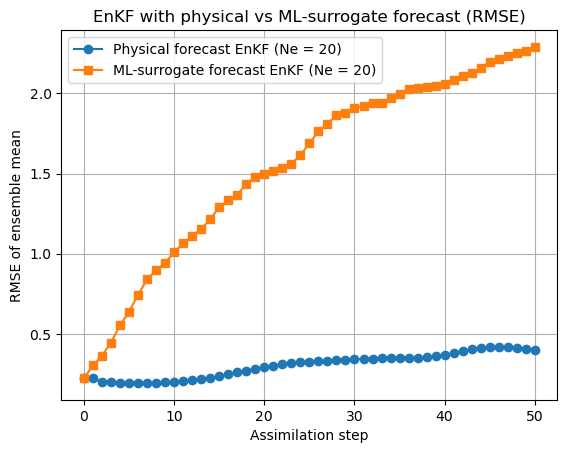

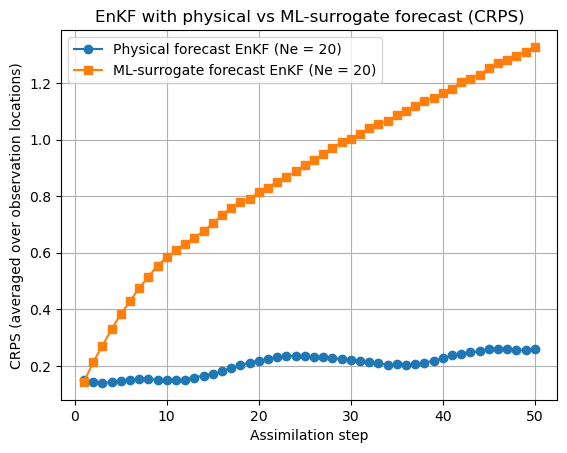

In [10]:
Ne_phys = 20

# Physical forecast EnKF
rmse_phys, means_phys, crps_phys = run_enkf(
    psi_truth=psi_truth,
    y_obs=y_obs,
    obs_idx=obs_idx,
    R=R,
    forecast_step=step_physical_ensemble,
    Ne=Ne_phys,
    sigma_init=1.0,
    inflation=1.0,
    seed=20,
    compute_crps=True,
    L_xy=None,
)

# ML-surrogate forecast EnKF
rmse_ml, means_ml, crps_ml = run_enkf(
    psi_truth=psi_truth,
    y_obs=y_obs,
    obs_idx=obs_idx,
    R=R,
    forecast_step=step_ml_ensemble,
    Ne=Ne_phys,
    sigma_init=1.0,
    inflation=1.0,
    seed=20,
    compute_crps=True,
    L_xy=None,
)

time_steps = np.arange(T + 1)

# RMSE comparison
plt.figure()
plt.plot(time_steps, rmse_phys, marker="o",
         label=f"Physical forecast EnKF (Ne = {Ne_phys})")
plt.plot(time_steps, rmse_ml, marker="s",
         label=f"ML-surrogate forecast EnKF (Ne = {Ne_phys})")
plt.xlabel("Assimilation step")
plt.ylabel("RMSE of ensemble mean")
plt.title("EnKF with physical vs ML-surrogate forecast (RMSE)")
plt.grid(True)
plt.legend()
plt.show()

# CRPS comparison in observation space
plt.figure()
plt.plot(time_steps, crps_phys, marker="o",
         label=f"Physical forecast EnKF (Ne = {Ne_phys})")
plt.plot(time_steps, crps_ml, marker="s",
         label=f"ML-surrogate forecast EnKF (Ne = {Ne_phys})")
plt.xlabel("Assimilation step")
plt.ylabel("CRPS (averaged over observation locations)")
plt.title("EnKF with physical vs ML-surrogate forecast (CRPS)")
plt.grid(True)
plt.legend()
plt.show()

In [11]:
ells = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
alpha = 1.02  # Ideally, we need to do a grid search, this is just to save the running time

for ell in ells:
    L_xy = build_localization_xy(nx, ny, n_layers, obs_idx, ell=ell, periodic=True)
    rmse, _, crps = run_enkf(
        psi_truth=psi_truth,
        y_obs=y_obs,
        obs_idx=obs_idx,
        R=R,
        forecast_step=step_physical_ensemble,
        Ne=20,
        sigma_init=1.0,
        inflation=alpha,
        seed=20,
        compute_crps=True,
        L_xy=L_xy,
    )
    print(f"ell={ell}: mean RMSE={rmse[1:].mean():.3f}, mean CRPS={crps[1:].mean():.3f}")


NameError: name 'nx' is not defined

L_xy shape: (36864, 288)
L_xy min, max: 7.124488377030502e-08 1.0
Any non-finite in L_xy? False


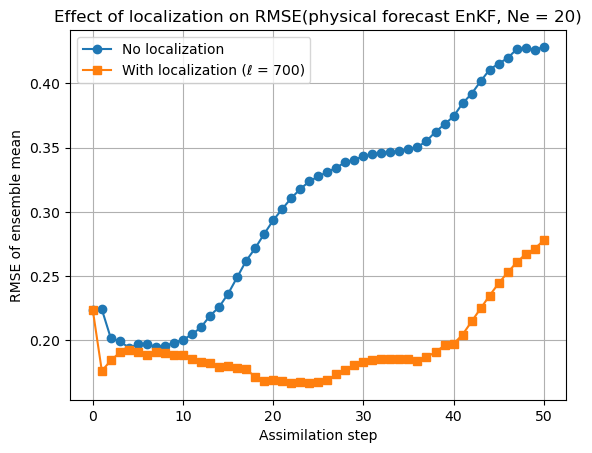

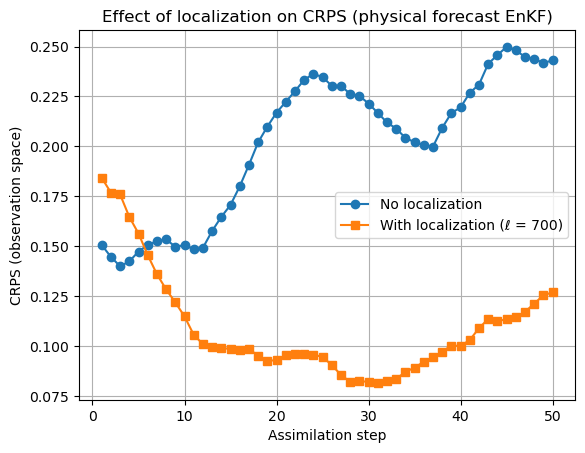

In [23]:
nx, ny, n_layers = psi_truth[0].shape
ell = 700            # localization length scale 
L_xy = build_localization_xy(nx, ny, n_layers, obs_idx, ell=ell, periodic=True)

Ne_loc = 20

# Physical-forecast EnKF without localization
rmse_noloc, _, crps_noloc = run_enkf(
    psi_truth=psi_truth,
    y_obs=y_obs,
    obs_idx=obs_idx,
    R=R,
    forecast_step=step_physical_ensemble,
    Ne=Ne_loc,
    sigma_init=1.0,
    inflation=1.02,
    seed=20,
    compute_crps=True,
    L_xy=None,
)

# Physical-forecast EnKF with localization
rmse_loc, _, crps_loc = run_enkf(
    psi_truth=psi_truth,
    y_obs=y_obs,
    obs_idx=obs_idx,
    R=R,
    forecast_step=step_physical_ensemble,
    Ne=Ne_loc,
    sigma_init=1.0,
    inflation=1.02,
    seed=20,
    compute_crps=True,
    L_xy=L_xy,
)

time_steps = np.arange(T + 1)

plt.figure()
plt.plot(time_steps, rmse_noloc, marker="o", label="No localization")
plt.plot(time_steps, rmse_loc,  marker="s", label=f"With localization (ℓ = {ell})")
plt.xlabel("Assimilation step")
plt.ylabel("RMSE of ensemble mean")
plt.title(f"Effect of localization on RMSE(physical forecast EnKF, Ne = {Ne_loc})")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(time_steps, crps_noloc, marker="o", label="No localization")
plt.plot(time_steps, crps_loc,  marker="s", label=f"With localization (ℓ = {ell})")
plt.xlabel("Assimilation step")
plt.ylabel("CRPS (observation space)")
plt.title("Effect of localization on CRPS (physical forecast EnKF)")
plt.grid(True)
plt.legend()
plt.show()

L_xy shape: (36864, 288)
L_xy min, max: 7.124488377030502e-08 1.0
Any non-finite in L_xy? False


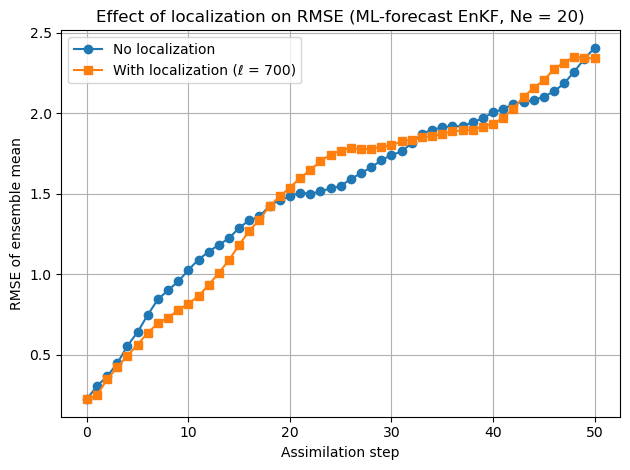

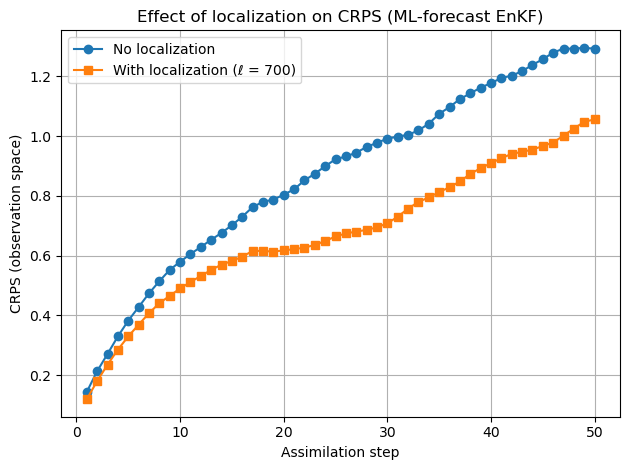

In [24]:
nx, ny, n_layers = psi_truth[0].shape
ell = 700            
L_xy = build_localization_xy(
    nx, ny, n_layers,
    obs_idx,
    ell=ell,
    periodic=True,
)

Ne_loc = 20
T = len(y_obs)
time_steps = np.arange(T + 1)

# ML-surrogate forecast EnKF WITHOUT localization
rmse_ml_noloc, _, crps_ml_noloc = run_enkf(
    psi_truth=psi_truth,
    y_obs=y_obs,
    obs_idx=obs_idx,
    R=R,
    forecast_step=step_ml_ensemble,
    Ne=Ne_loc,
    sigma_init=1.0,
    inflation=1.02,
    seed=20,
    compute_crps=True,
    L_xy=None,                   
)


# ML-surrogate forecast EnKF WITH localization
rmse_ml_loc, _, crps_ml_loc = run_enkf(
    psi_truth=psi_truth,
    y_obs=y_obs,
    obs_idx=obs_idx,
    R=R,
    forecast_step=step_ml_ensemble, 
    Ne=Ne_loc,
    sigma_init=1.0,
    inflation=1.02,
    seed=20,
    compute_crps=True,
    L_xy=L_xy,       
)


# Plots: RMSE
plt.figure()
plt.plot(time_steps, rmse_ml_noloc, marker="o", label="No localization")
plt.plot(time_steps, rmse_ml_loc,  marker="s", label=f"With localization (ℓ = {ell})")
plt.xlabel("Assimilation step")
plt.ylabel("RMSE of ensemble mean")
plt.title(f"Effect of localization on RMSE (ML-forecast EnKF, Ne = {Ne_loc})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Plots: CRPS
plt.figure()
plt.plot(time_steps, crps_ml_noloc, marker="o", label="No localization")
plt.plot(time_steps, crps_ml_loc,  marker="s", label=f"With localization (ℓ = {ell})")
plt.xlabel("Assimilation step")
plt.ylabel("CRPS (observation space)")
plt.title("Effect of localization on CRPS (ML-forecast EnKF)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Running EnKF with Ne = 5 ...
Running EnKF with Ne = 10 ...
Running EnKF with Ne = 20 ...
Running EnKF with Ne = 40 ...


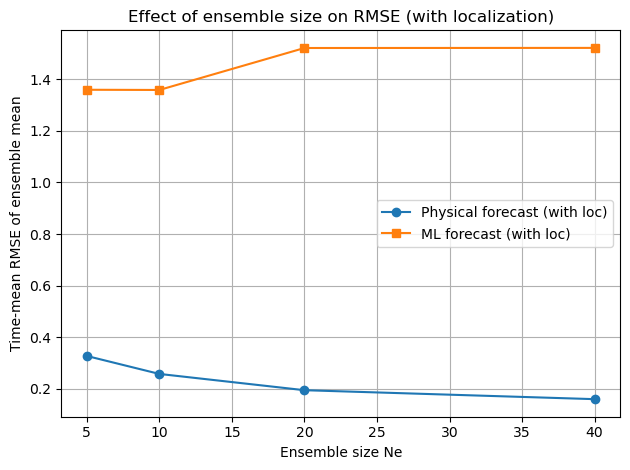

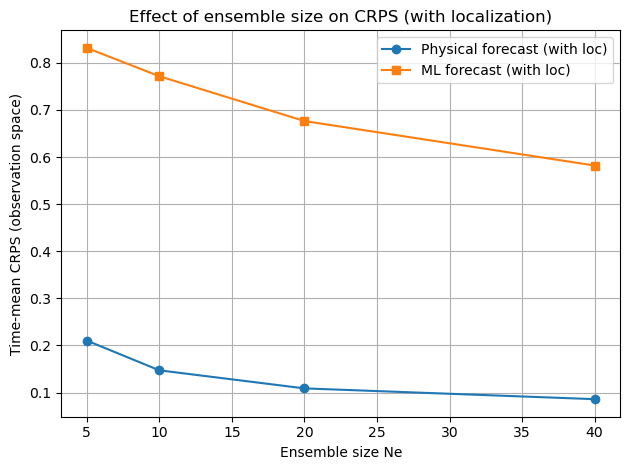

In [25]:
Ne_list = [5, 10, 20, 40]
inflation = 1.02
seed = 20
T = len(y_obs)
time_steps = np.arange(T + 1)

# containers
mean_rmse_phys = []
mean_rmse_ml   = []
mean_crps_phys = []
mean_crps_ml   = []

for Ne in Ne_list:
    print(f"Running EnKF with Ne = {Ne} ...")

    # Physical-forecast EnKF with localization
    rmse_phys, _, crps_phys = run_enkf(
        psi_truth=psi_truth,
        y_obs=y_obs,
        obs_idx=obs_idx,
        R=R,
        forecast_step=step_physical_ensemble,
        Ne=Ne,
        sigma_init=1.0,
        inflation=inflation,
        seed=seed,
        compute_crps=True,
        L_xy=L_xy,  
    )

    # ML-forecast EnKF with localization
    rmse_ml, _, crps_ml = run_enkf(
        psi_truth=psi_truth,
        y_obs=y_obs,
        obs_idx=obs_idx,
        R=R,
        forecast_step=step_ml_ensemble,
        Ne=Ne,
        sigma_init=1.0,
        inflation=inflation,
        seed=seed,
        compute_crps=True,
        L_xy=L_xy,    
    )

    # time-mean over t = 1..T (skip t=0, which is initial condition)
    mean_rmse_phys.append(rmse_phys[1:].mean())
    mean_rmse_ml.append(rmse_ml[1:].mean())
    mean_crps_phys.append(crps_phys[1:].mean())
    mean_crps_ml.append(crps_ml[1:].mean())

# plot: time–mean RMSE vs Ne
plt.figure()
plt.plot(Ne_list, mean_rmse_phys, "-o", label="Physical forecast (with loc)")
plt.plot(Ne_list, mean_rmse_ml,   "-s", label="ML forecast (with loc)")
plt.xlabel("Ensemble size Ne")
plt.ylabel("Time-mean RMSE of ensemble mean")
plt.title("Effect of ensemble size on RMSE (with localization)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# plot: time–mean CRPS vs Ne
plt.figure()
plt.plot(Ne_list, mean_crps_phys, "-o", label="Physical forecast (with loc)")
plt.plot(Ne_list, mean_crps_ml,   "-s", label="ML forecast (with loc)")
plt.xlabel("Ensemble size Ne")
plt.ylabel("Time-mean CRPS (observation space)")
plt.title("Effect of ensemble size on CRPS (with localization)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
